In [1]:
%reset -fs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.figsize" : (10,10),
          "axes.titlecolor" : 'w'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
image_size = (128,128)
batch_size = 32

In [5]:
train_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


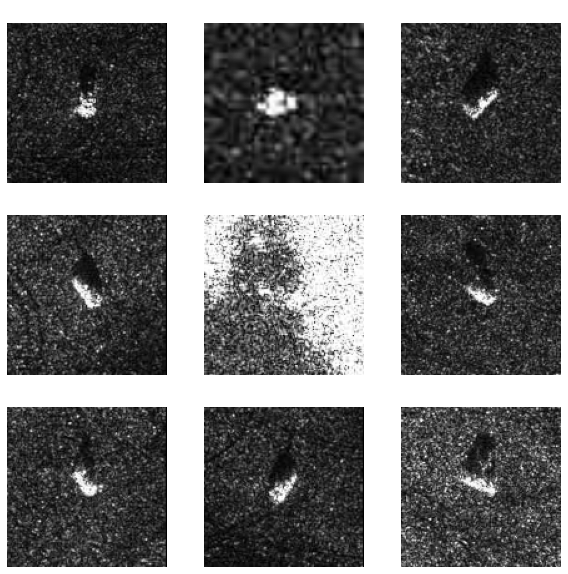

In [6]:
class_names = train_ds.class_names
with plt.rc_context(params):
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
      plt.title(class_names[np.argmax(labels[i])], )
      plt.axis("off")

In [7]:
class_names

['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 54
Number of test batches: 13


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes=9

metrics = [
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tfa.metrics.MatthewsCorrelationCoefficient(num_classes=9, name='MCC'),
      tfa.metrics.FBetaScore(num_classes=9, average='weighted', beta=2.0, name='F2'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [11]:
model1 = keras.Sequential()

model1.add(InputLayer(input_shape=(image_size + (1,))))

model1.add(Flatten())

model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))

model1.add(Dense(num_classes, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1638500   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 1,659,609
Trainable params: 1,659,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

In [13]:
history1 = model1.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 7s 13ms/step - loss: 57.7855 - categorical_accuracy: 0.4723 - MCC: 0.4027 - F2: 0.4715 - auc: 0.7316 - prc: 0.3516 - val_loss: 2.1408 - val_categorical_accuracy: 0.7686 - val_MCC: 0.7414 - val_F2: 0.7658 - val_auc: 0.9275 - val_prc: 0.7768
Epoch 2/10
265/265 [==============================] - 3s 11ms/step - loss: 1.9459 - categorical_accuracy: 0.8080 - MCC: 0.7829 - F2: 0.8079 - auc: 0.9371 - prc: 0.8074 - val_loss: 9.0835 - val_categorical_accuracy: 0.5161 - val_MCC: 0.4769 - val_F2: 0.4762 - val_auc: 0.7723 - val_prc: 0.4224
Epoch 3/10
265/265 [==============================] - 3s 10ms/step - loss: 3.0673 - categorical_accuracy: 0.7866 - MCC: 0.7586 - F2: 0.7866 - auc: 0.9163 - prc: 0.7618 - val_loss: 1.0984 - val_categorical_accuracy: 0.8743 - val_MCC: 0.8626 - val_F2: 0.8725 - val_auc: 0.9585 - val_prc: 0.8722
Epoch 4/10
265/265 [==============================] - 3s 10ms/step - loss: 1.1364 - categorical_accuracy: 0.8819 - MCC: 

In [14]:
def holdout_results(model):
    result = model.evaluate(test_ds)
    return dict(zip(model.metrics_names, result))
    

In [15]:
def plot_metrics(history):
  with plt.rc_context(params):    
    metrics = ['loss', 'prc', 'F2', 'MCC']
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      elif metric == 'MCC':
        plt.ylim([-1,1])
      else:
        plt.ylim([0,1])

      plt.legend();

In [16]:
def plot_cm(model, data):
    with plt.rc_context(params):
        y_true = []
        y_pred = []
        for x,y in data:
            y= tf.argmax(y,axis=1)
            y_true.append(y)
            y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.concat(y_true, axis=0)

        cm = confusion_matrix(y_true, y_pred)
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(1,1,1)
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(cm,cmap='binary', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
            cbar = False);
        ax1.set_ylabel('True Values',fontsize=14)
        ax1.set_xlabel('Predicted Values',fontsize=14)
        plt.show()

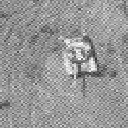

In [17]:
image = keras.utils.load_img(
    path="C:\\Users\\nated\\Documents\\GitHub\\sar_target_recognition_deep_learning\\holdout_imgs\\t72_kuwait.jpg",
    color_mode='grayscale',
    target_size=(128,128)
)

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

image

In [18]:
def predict_t72(model):
    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])
    return(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

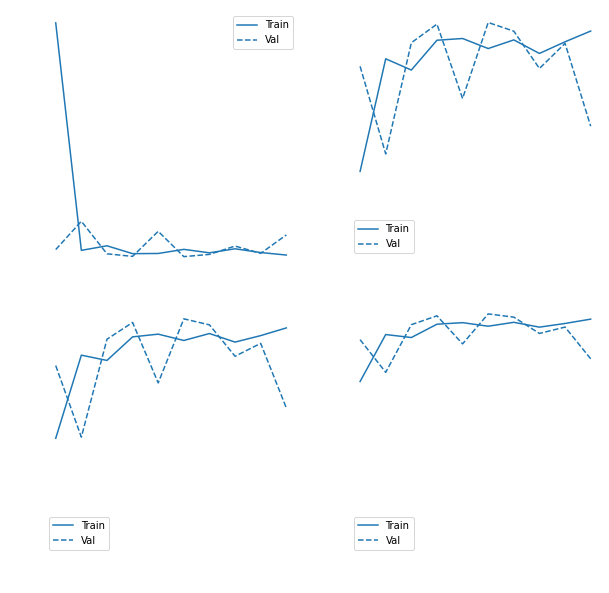

In [19]:
plot_metrics(history1)

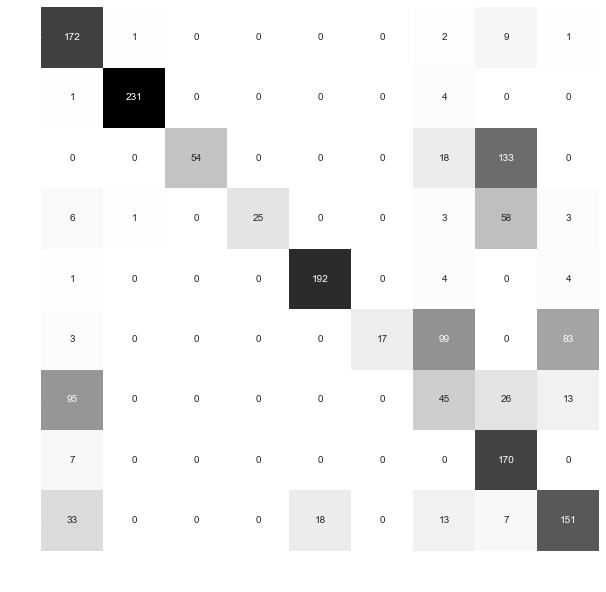

In [20]:
plot_cm(model1, val_ds)

In [21]:
holdout_results(model1)

13/13 [==============================] - 0s 13ms/step - loss: 5.8743 - categorical_accuracy: 0.6250 - MCC: 0.5892 - F2: 0.6039 - auc: 0.8271 - prc: 0.5252


{'loss': 5.874292373657227,
 'categorical_accuracy': 0.625,
 'MCC': 0.5892224907875061,
 'F2': 0.6039168834686279,
 'auc': 0.8270519971847534,
 'prc': 0.5252355933189392}

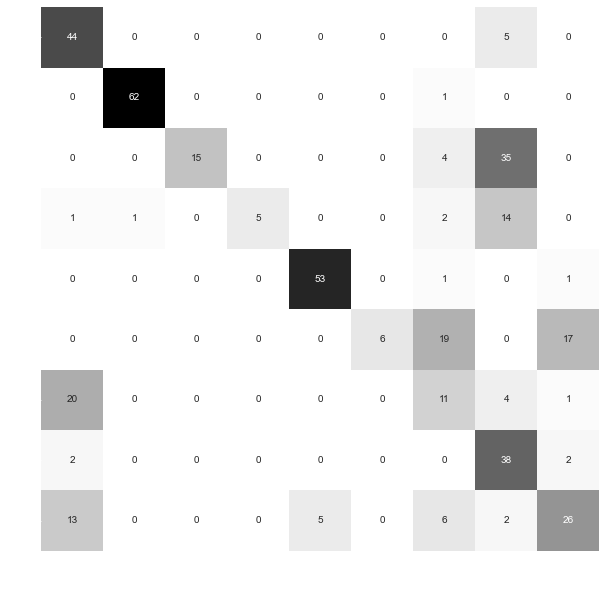

In [22]:
plot_cm(model1, test_ds)

In [23]:
predict_t72(model1)

'This image most likely belongs to 2S1 with a 25.36 percent confidence.'

In [24]:
model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (1,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)       

In [25]:
model2.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)


In [26]:
history2 = model2.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 52s 187ms/step - loss: 0.8292 - categorical_accuracy: 0.7106 - MCC: 0.6725 - F2: 0.7094 - auc: 0.9477 - prc: 0.7891 - val_loss: 0.1632 - val_categorical_accuracy: 0.9577 - val_MCC: 0.9526 - val_F2: 0.9570 - val_auc: 0.9989 - val_prc: 0.9922
Epoch 2/10
265/265 [==============================] - 26s 100ms/step - loss: 0.1175 - categorical_accuracy: 0.9679 - MCC: 0.9637 - F2: 0.9679 - auc: 0.9985 - prc: 0.9933 - val_loss: 0.1027 - val_categorical_accuracy: 0.9683 - val_MCC: 0.9645 - val_F2: 0.9680 - val_auc: 0.9994 - val_prc: 0.9954
Epoch 3/10
265/265 [==============================] - 6s 23ms/step - loss: 0.0398 - categorical_accuracy: 0.9914 - MCC: 0.9903 - F2: 0.9914 - auc: 0.9998 - prc: 0.9992 - val_loss: 0.0152 - val_categorical_accuracy: 0.9971 - val_MCC: 0.9967 - val_F2: 0.9971 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 4/10
265/265 [==============================] - 5s 18ms/step - loss: 0.0500 - categorical_accuracy: 0.9848 - MC

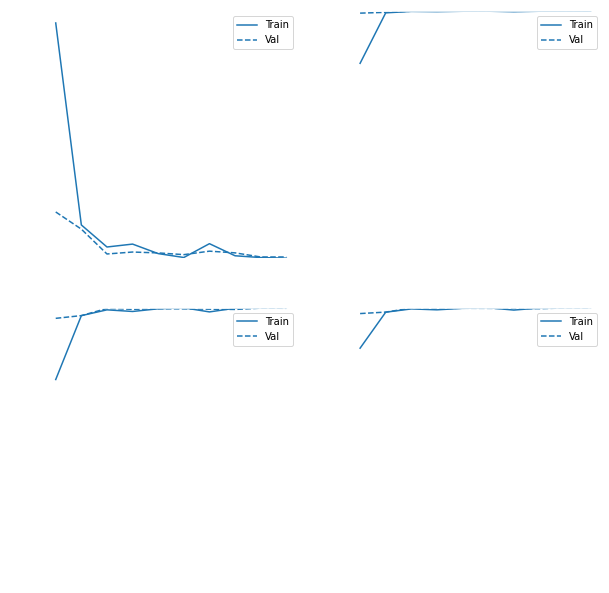

In [27]:
plot_metrics(history2)

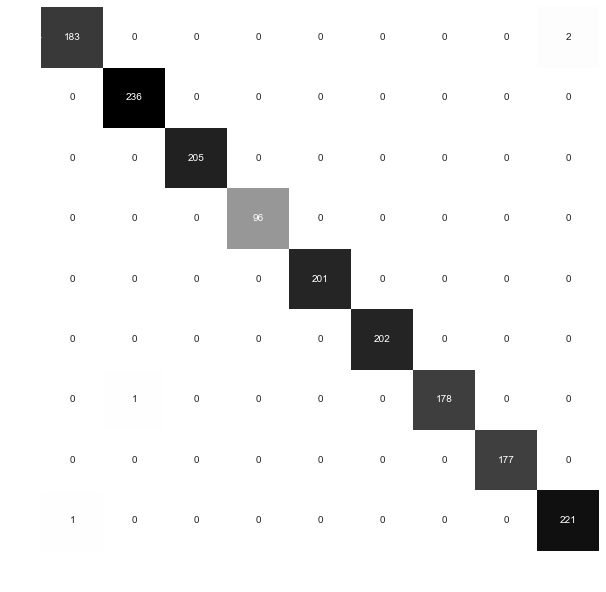

In [28]:
plot_cm(model2, val_ds)

In [29]:
holdout_results(model2)

13/13 [==============================] - 0s 15ms/step - loss: 0.0074 - categorical_accuracy: 0.9952 - MCC: 0.9946 - F2: 0.9952 - auc: 1.0000 - prc: 1.0000


{'loss': 0.007411548867821693,
 'categorical_accuracy': 0.995192289352417,
 'MCC': 0.9945772290229797,
 'F2': 0.9951702356338501,
 'auc': 0.9999956488609314,
 'prc': 0.9999654293060303}

In [30]:
predict_t72(model2)

'This image most likely belongs to BRDM_2 with a 20.32 percent confidence.'

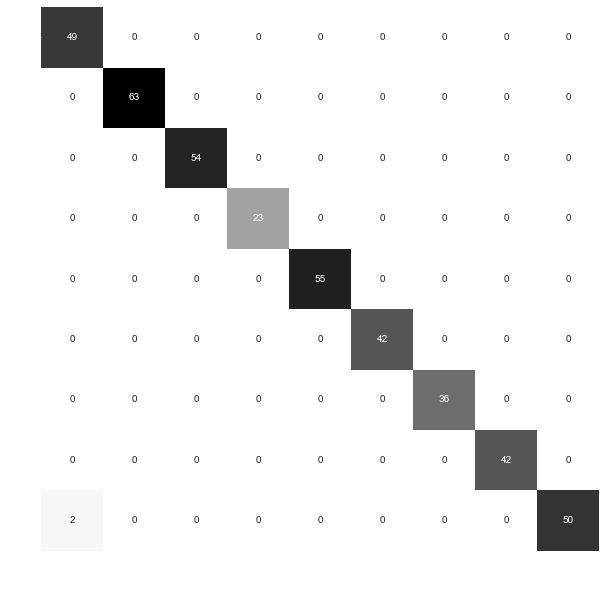

In [31]:
plot_cm(model2, test_ds)

In [32]:
CNN = Sequential()
CNN.add(InputLayer(input_shape=(image_size + (1,))))
CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
CNN.add(GlobalAveragePooling2D())
CNN.add(Dense(20, activation='relu'))
CNN.add(Dense(num_classes, activation='softmax'))
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 30)        5430      
_________________________________________________________________
global_average_pooling2d (Gl (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)               

In [33]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [34]:
cnn_hist = CNN.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 5s 14ms/step - loss: 2.0505 - categorical_accuracy: 0.2881 - MCC: 0.2033 - F2: 0.2630 - auc: 0.6869 - prc: 0.3248 - val_loss: 1.5702 - val_categorical_accuracy: 0.3617 - val_MCC: 0.3378 - val_F2: 0.2840 - val_auc: 0.8195 - val_prc: 0.5125
Epoch 2/10
265/265 [==============================] - 3s 12ms/step - loss: 1.0975 - categorical_accuracy: 0.5678 - MCC: 0.5128 - F2: 0.5568 - auc: 0.9253 - prc: 0.6960 - val_loss: 0.6359 - val_categorical_accuracy: 0.7592 - val_MCC: 0.7315 - val_F2: 0.7471 - val_auc: 0.9770 - val_prc: 0.8657
Epoch 3/10
265/265 [==============================] - 3s 12ms/step - loss: 0.6214 - categorical_accuracy: 0.7426 - MCC: 0.7104 - F2: 0.7326 - auc: 0.9756 - prc: 0.8611 - val_loss: 0.5609 - val_categorical_accuracy: 0.7546 - val_MCC: 0.7402 - val_F2: 0.7228 - val_auc: 0.9804 - val_prc: 0.8852
Epoch 4/10
265/265 [==============================] - 3s 12ms/step - loss: 0.5023 - categorical_accuracy: 0.7826 - MCC: 0

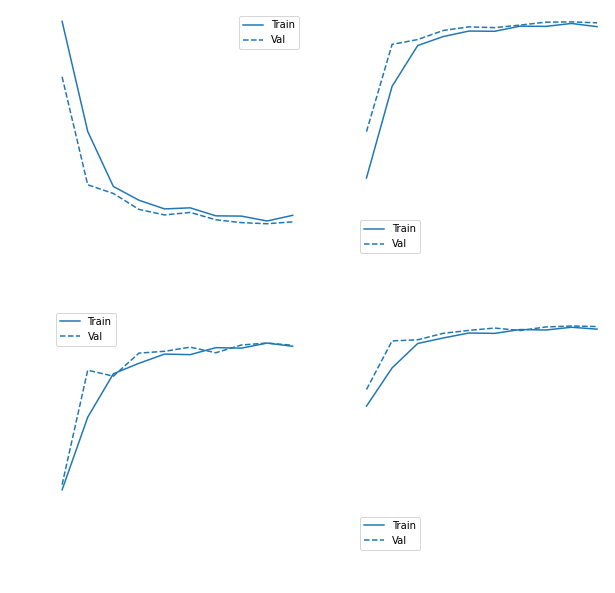

In [35]:
plot_metrics(cnn_hist)

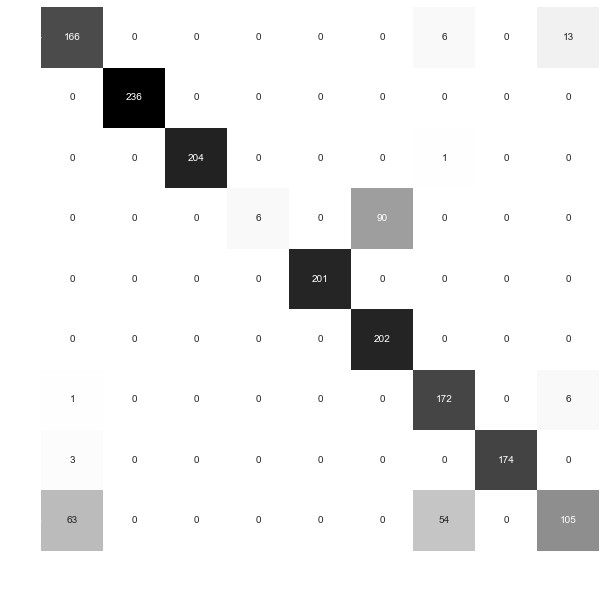

In [36]:
plot_cm(CNN, val_ds)

In [37]:
holdout_results(CNN)

13/13 [==============================] - 0s 10ms/step - loss: 0.3223 - categorical_accuracy: 0.8558 - MCC: 0.8404 - F2: 0.8461 - auc: 0.9928 - prc: 0.9496


{'loss': 0.322255939245224,
 'categorical_accuracy': 0.8557692170143127,
 'MCC': 0.8403691649436951,
 'F2': 0.8460667729377747,
 'auc': 0.992820680141449,
 'prc': 0.9496146440505981}

In [38]:
predict_t72(CNN)

'This image most likely belongs to 2S1 with a 20.00 percent confidence.'

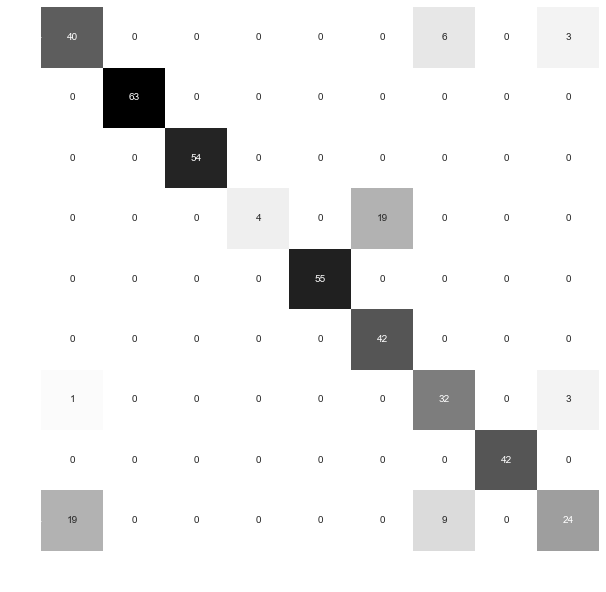

In [39]:
plot_cm(CNN, test_ds)

In [40]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.Resizing(128,128),
  keras.layers.Rescaling(1./255)])

In [41]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.1),
    ]
)

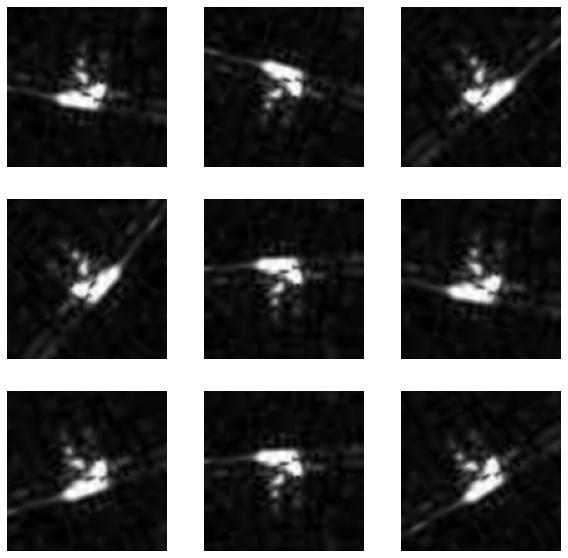

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [43]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


xception = make_model(input_shape=image_size + (1,), num_classes=9)
xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128, 128, 1)  0           sequential_3[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         sequential_4[0][0]               
______________________________________________________________________________________________

In [44]:
callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_F2', mode='max', restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,
)
xception_hist = xception.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 27s 90ms/step - loss: 1.0623 - categorical_accuracy: 0.6220 - MCC: 0.5721 - F2: 0.6207 - auc: 0.9333 - prc: 0.7163 - val_loss: 5.9196 - val_categorical_accuracy: 0.1286 - val_MCC: -0.0033 - val_F2: 0.0564 - val_auc: 0.5092 - val_prc: 0.1210
Epoch 2/100
265/265 [==============================] - 22s 83ms/step - loss: 0.5455 - categorical_accuracy: 0.8032 - MCC: 0.7774 - F2: 0.8032 - auc: 0.9798 - prc: 0.8916 - val_loss: 6.0195 - val_categorical_accuracy: 0.1644 - val_MCC: 0.1110 - val_F2: 0.1064 - val_auc: 0.5820 - val_prc: 0.1678
Epoch 3/100
265/265 [==============================] - 22s 85ms/step - loss: 0.3616 - categorical_accuracy: 0.8722 - MCC: 0.8555 - F2: 0.8722 - auc: 0.9906 - prc: 0.9456 - val_loss: 0.8335 - val_categorical_accuracy: 0.7287 - val_MCC: 0.7070 - val_F2: 0.7133 - val_auc: 0.9593 - val_prc: 0.8191
Epoch 4/100
265/265 [==============================] - 22s 83ms/step - loss: 0.2807 - categorical_accuracy: 0.9001

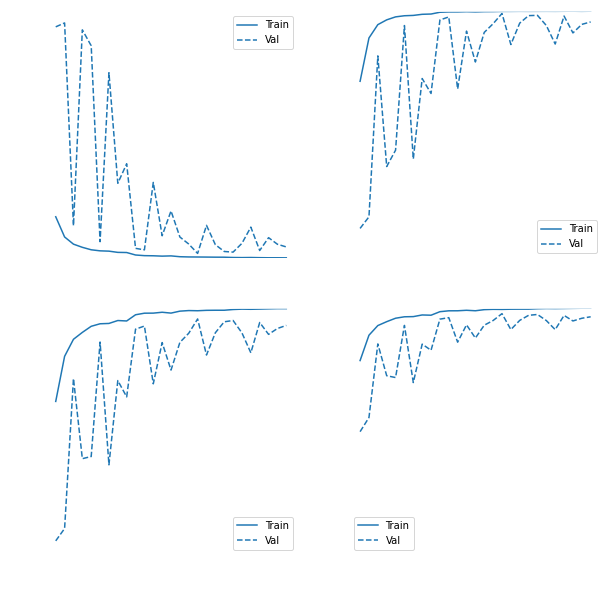

In [45]:
plot_metrics(xception_hist)

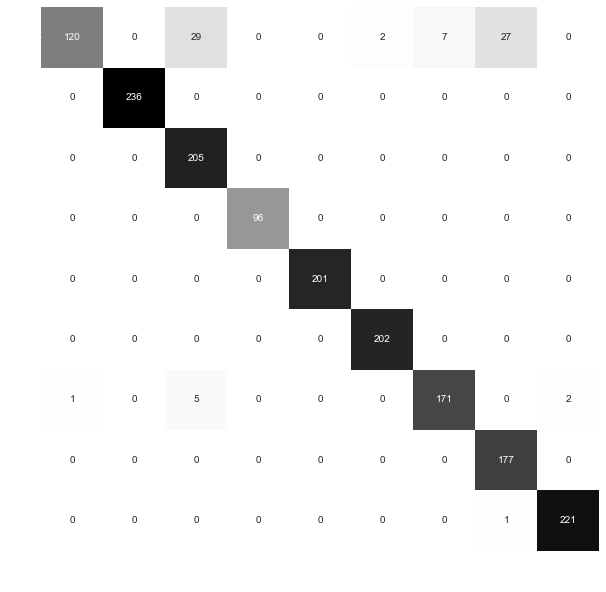

In [46]:
plot_cm(xception, val_ds)

In [47]:
holdout_results(xception)

13/13 [==============================] - 0s 20ms/step - loss: 0.1515 - categorical_accuracy: 0.9495 - MCC: 0.9447 - F2: 0.9465 - auc: 0.9976 - prc: 0.9883


{'loss': 0.15149539709091187,
 'categorical_accuracy': 0.9495192170143127,
 'MCC': 0.9446666240692139,
 'F2': 0.9464870691299438,
 'auc': 0.9976416826248169,
 'prc': 0.98832106590271}

In [48]:
predict_t72(xception)

'This image most likely belongs to ZIL131 with a 18.97 percent confidence.'

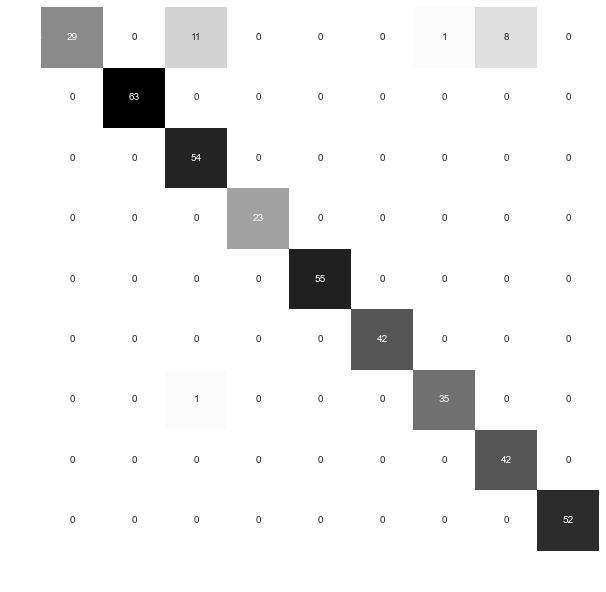

In [49]:
plot_cm(xception,test_ds)

In [50]:
train_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='rgb',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='rgb',
                                           batch_size=batch_size)

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


In [51]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 54
Number of test batches: 13


In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

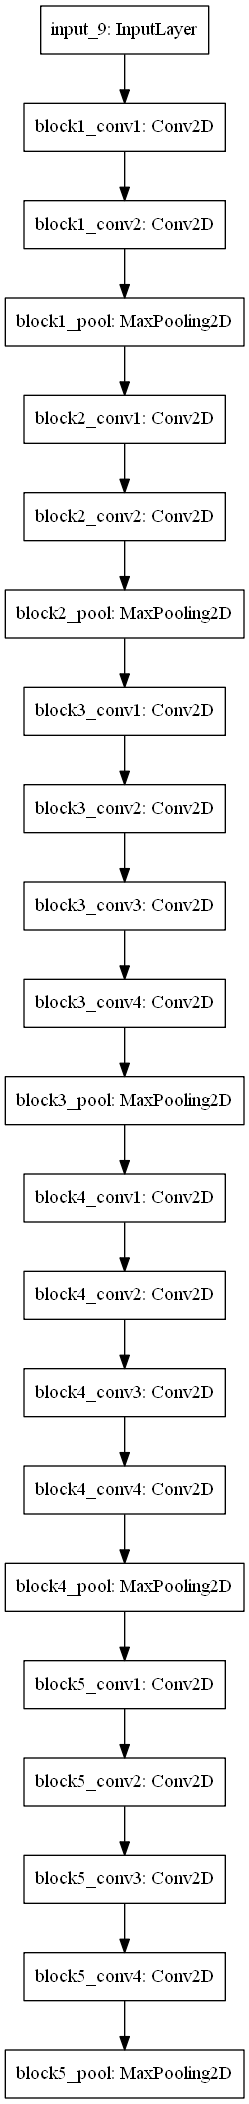

In [70]:
vgg_base = VGG19(include_top=False, weights= 'imagenet', input_shape=(128, 128, 3))
keras.utils.plot_model(vgg_base)

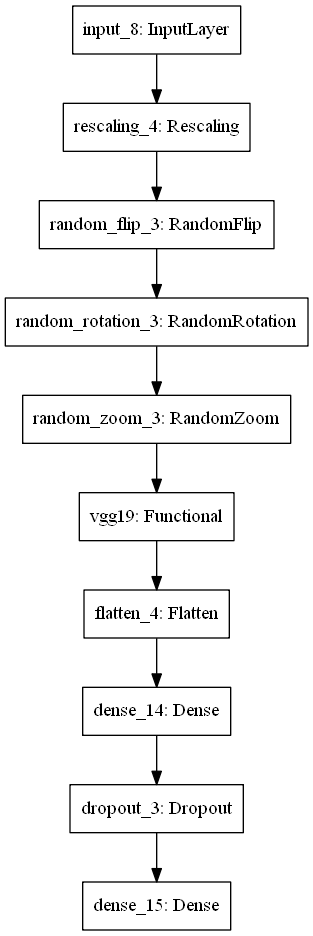

In [69]:
vgg_model = keras.models.Sequential()
vgg_model.add(Input(shape=image_size + (3,)))
vgg_model.add(Rescaling(1./255))
vgg_model.add(RandomFlip('horizontal_and_vertical'))
vgg_model.add(RandomRotation(0.2))
vgg_model.add(RandomZoom(0.1))
vgg_model.add(vgg_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(num_classes, activation='softmax'))


keras.utils.plot_model(vgg_model)

In [55]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,)

vgg_hist = vgg_model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 35s 112ms/step - loss: 2.1231 - categorical_accuracy: 0.2357 - MCC: 0.1301 - F2: 0.2217 - auc: 0.6819 - prc: 0.2748 - val_loss: 2.0417 - val_categorical_accuracy: 0.2255 - val_MCC: 0.1704 - val_F2: 0.1643 - val_auc: 0.6726 - val_prc: 0.1877
Epoch 2/100
265/265 [==============================] - 28s 104ms/step - loss: 1.7417 - categorical_accuracy: 0.3059 - MCC: 0.2119 - F2: 0.2925 - auc: 0.7745 - prc: 0.3650 - val_loss: 1.6974 - val_categorical_accuracy: 0.3130 - val_MCC: 0.2604 - val_F2: 0.2650 - val_auc: 0.7847 - val_prc: 0.3924
Epoch 3/100
265/265 [==============================] - 27s 104ms/step - loss: 1.6710 - categorical_accuracy: 0.3223 - MCC: 0.2313 - F2: 0.3085 - auc: 0.7955 - prc: 0.3927 - val_loss: 2.2480 - val_categorical_accuracy: 0.2079 - val_MCC: 0.1530 - val_F2: 0.1536 - val_auc: 0.6952 - val_prc: 0.2900
Epoch 4/100
265/265 [==============================] - 28s 104ms/step - loss: 1.6572 - categorical_accuracy: 0.3

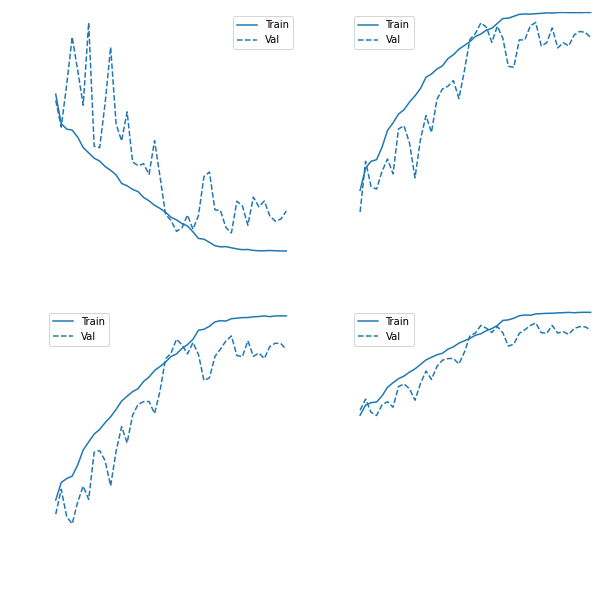

In [56]:
plot_metrics(vgg_hist)

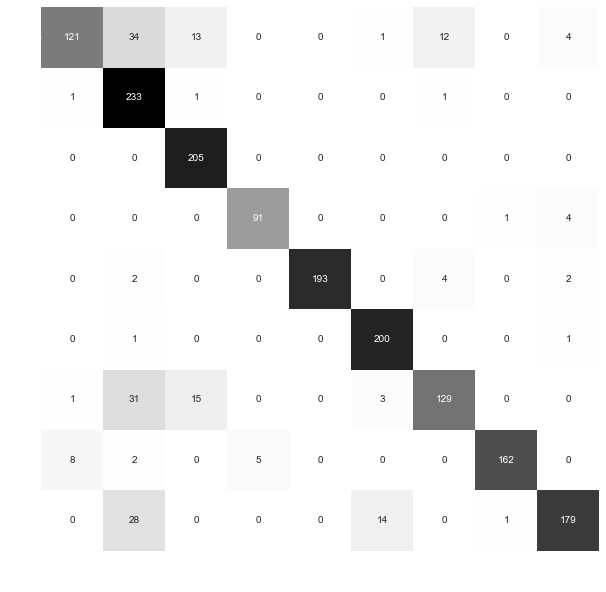

In [57]:
plot_cm(vgg_model, val_ds)

In [58]:
holdout_results(vgg_model)

13/13 [==============================] - 1s 42ms/step - loss: 0.4055 - categorical_accuracy: 0.8678 - MCC: 0.8520 - F2: 0.8650 - auc: 0.9856 - prc: 0.9381


{'loss': 0.40552711486816406,
 'categorical_accuracy': 0.8677884340286255,
 'MCC': 0.8520011305809021,
 'F2': 0.8649522066116333,
 'auc': 0.9856072068214417,
 'prc': 0.9381122589111328}

In [59]:
image = keras.utils.load_img(
    path="C:\\Users\\nated\\Documents\\GitHub\\sar_target_recognition_deep_learning\\holdout_imgs\\t72_kuwait.jpg",
    color_mode='rgb',
    target_size=(128,128)
)

image

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

In [60]:
predict_t72(vgg_model)

'This image most likely belongs to 2S1 with a 15.09 percent confidence.'

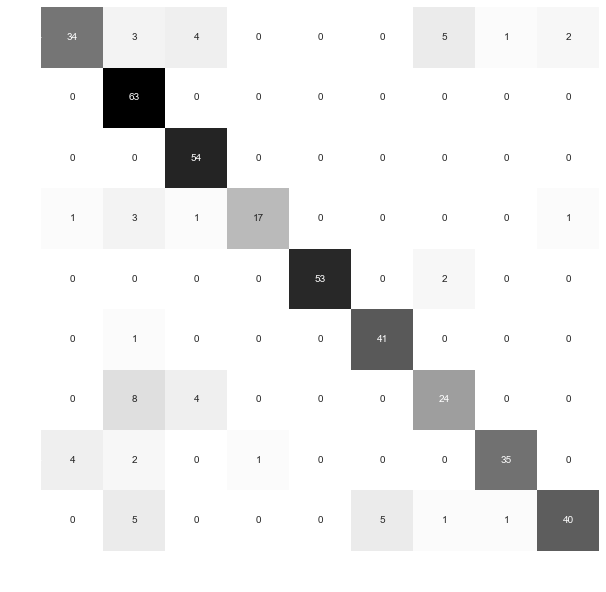

In [61]:
plot_cm(vgg_model,test_ds)

In [62]:
last_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (3,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Conv2D(128, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
last_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 124, 124, 128)     9728      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 59, 59, 64)       

In [63]:
last_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,)

last_model_hist = last_model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 13s 42ms/step - loss: 1.7068 - categorical_accuracy: 0.3629 - MCC: 0.2776 - F2: 0.3536 - auc: 0.8082 - prc: 0.4352 - val_loss: 1.1687 - val_categorical_accuracy: 0.5185 - val_MCC: 0.4696 - val_F2: 0.4848 - val_auc: 0.9179 - val_prc: 0.6516
Epoch 2/100
265/265 [==============================] - 10s 38ms/step - loss: 1.2435 - categorical_accuracy: 0.5353 - MCC: 0.4737 - F2: 0.5322 - auc: 0.9011 - prc: 0.6160 - val_loss: 0.8020 - val_categorical_accuracy: 0.7035 - val_MCC: 0.6696 - val_F2: 0.6935 - val_auc: 0.9613 - val_prc: 0.8021
Epoch 3/100
265/265 [==============================] - 10s 38ms/step - loss: 0.9292 - categorical_accuracy: 0.6629 - MCC: 0.6187 - F2: 0.6611 - auc: 0.9455 - prc: 0.7530 - val_loss: 0.7326 - val_categorical_accuracy: 0.7064 - val_MCC: 0.6759 - val_F2: 0.6914 - val_auc: 0.9661 - val_prc: 0.8228
Epoch 4/100
265/265 [==============================] - 10s 38ms/step - loss: 0.7432 - categorical_accuracy: 0.7328 

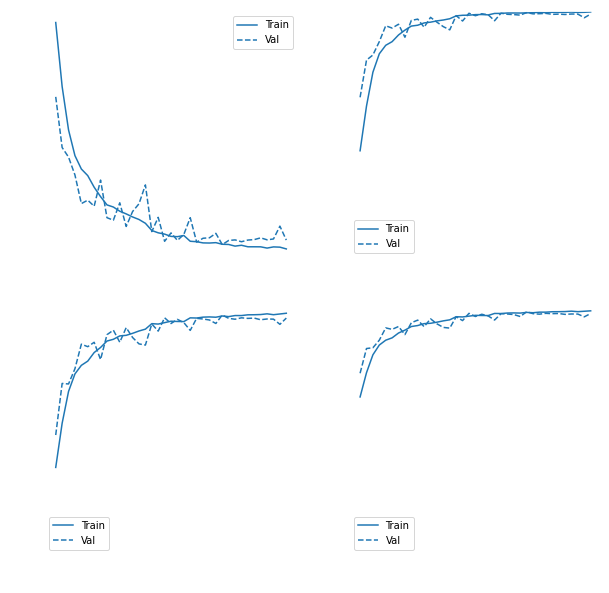

In [64]:
plot_metrics(last_model_hist)

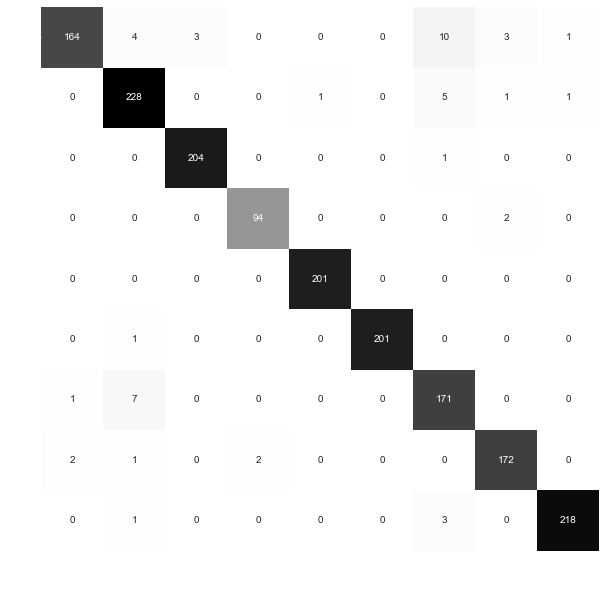

In [65]:
plot_cm(last_model, val_ds)

In [66]:
holdout_results(last_model)

13/13 [==============================] - 0s 17ms/step - loss: 0.0842 - categorical_accuracy: 0.9760 - MCC: 0.9729 - F2: 0.9760 - auc: 0.9982 - prc: 0.9921


{'loss': 0.08423148095607758,
 'categorical_accuracy': 0.9759615659713745,
 'MCC': 0.9728712439537048,
 'F2': 0.9759683609008789,
 'auc': 0.9981577396392822,
 'prc': 0.9921144843101501}

In [67]:
predict_t72(last_model)

'This image most likely belongs to BRDM_2 with a 22.98 percent confidence.'

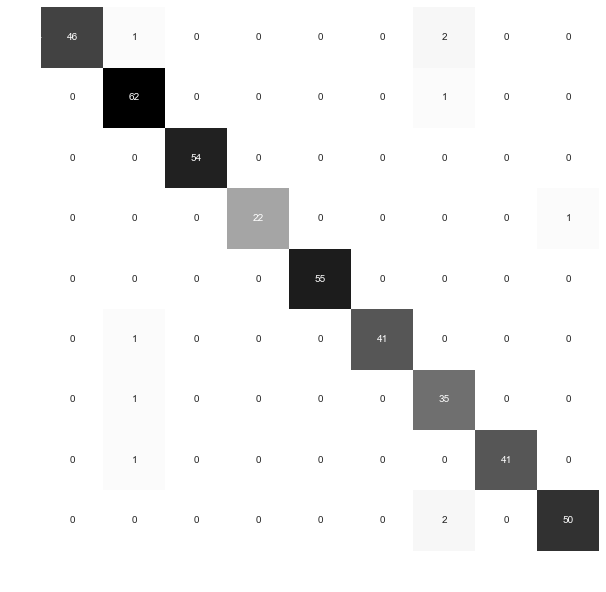

In [68]:
plot_cm(last_model, test_ds)